In [1]:
import pandas as pd
import numpy as np
import os
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
import sklearn.preprocessing as skp
import sklearn.decomposition as skd
import sklearn.svm as svm
from sklearn.metrics import f1_score, accuracy_score, classification_report

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

import seaborn as sns

import warnings

In [2]:
saveloc = os.getcwd()

# Portfolio Project 
### for the Imperial College Business School Course "Professional Certificate in Machine Learning and Artifical Intelligence

#### Author: Jakob-Wendelin Genger

## Task and Project Description

The instructions for the portfolio project were to choose a dataset that is related to my field of work and to solve the presented problem with one of the machine learning models I learned about in this programme. 

I chose the "Breast Cancer Wisconsin (Diagnostic) Data Set" provided by UCI Machine Learning on kaggle (https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data?resource=download). 

The dataset provides 30 measured features that characterise cell nuclei in images of fine needle aspirates (FNA) of breast masses obtained from patients, a sample ID and the diagnosis of the patients as outcome variable.

The task for this dataset is to predict whether the presented cancer is malign or benign based on the features of the nuclei.

### Import dataset

In [3]:
data_file = open(saveloc+"/data.csv")
data = pd.read_csv(data_file)
data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


### Divide dataset into a dataframe with features and a dataframe with the target variable

Remove unnecessary features "ID" and "Unnamed: 32"

In [4]:
#Target/Outcome variable - transform M for 'malign' and B for 'benign' to 0 and 1
target = (data["diagnosis"].to_numpy()=='M').astype(np.uint8)

#Features of nuclei
features = data.loc[:, data.columns != 'diagnosis'].drop(columns=['id', 'Unnamed: 32'], inplace=False)

### PCA plot

We perform first a PCA analysis to get an idea of the distribution of the dataset and most important drivers of variance and check whether we can identify features that drive difference between the two classes 'benign' and 'malign'.

    First step: scaling features to get them into the same number space
    Second step: PCA analysis
    Third step: Visualisation of PCA1 and PCA2 coloured by outcome variable (diagnosis)

In [5]:
# First step: Scaling features
scaler = skp.StandardScaler()

scaler.fit(features)
scaled_features = scaler.transform(features)

In [6]:
# Second step: PCA analysis
pca = skd.PCA(n_components=2)

pca.fit(scaled_features)
pca_scatter = pca.fit_transform(scaled_features)

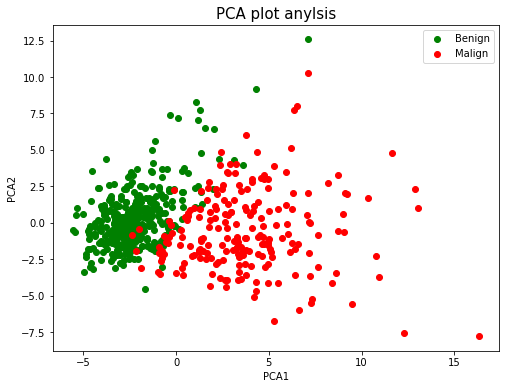

In [7]:
# Third step: Visualization of PCA1 and PCA2

plt.figure(figsize=(8, 6))

plt.scatter(pca_scatter[:,0][target==0], pca_scatter[:,1][target==0], c = "green", label="Benign")
plt.scatter(pca_scatter[:,0][target==1], pca_scatter[:,1][target==1], c = "red", label="Malign")

plt.xlabel("PCA1", size=10)
plt.ylabel("PCA2", size=10)
plt.title("PCA plot anylsis", size=15)
plt.legend()

In [8]:
print("The principal component analysis showed that",pca.explained_variance_ratio_[0]*100,
      "% of the variance can be explained by PCA1 \nand",pca.explained_variance_ratio_[1]*100,
     "% of the variance can be explained by PCA2.")

print("\nFrom the distribution of datapoints in the PCA plot we can assume that we should be able",
      "to discriminate the two classes of samples well.")

The principal component analysis showed that 44.27202560752641 % of the variance can be explained by PCA1 
and 18.971182044033092 % of the variance can be explained by PCA2.

From the distribution of datapoints in the PCA plot we can assume that we should be able to discriminate the two classes of samples well.


In [9]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features.columns)
print(loadings)

print("\nThe lists above show the loadings of each feature for the first two principal components.\n",
      "Loadings are the coefficients of the linear combination of the original variables from which the PCs\n",
      "are constructed and range between -1 and 1. The loadings represent how much each feature influences the component.\n",
      "A feature has greater influence on a component the closer the score of a feature is to to -1 or 1.\n",
     "Loading scores of 0 indicate a weak influence on the component.\n\n",
     "In the list provided above we see that the majority of features has loading scores over 0.1 or even 0.2",
     "and that there is few scores that are very close to 0. This means the components are not driven by a",
     "single or few features but rather influenced by most of the features. Therefore, we will probably not",
     "be able to come up with a model that identifies a single feature as the best predictor for",
     "the outcome variable (diagnosis).")

                              PC1       PC2
radius_mean              0.218902 -0.233857
texture_mean             0.103725 -0.059706
perimeter_mean           0.227537 -0.215181
area_mean                0.220995 -0.231077
smoothness_mean          0.142590  0.186113
compactness_mean         0.239285  0.151892
concavity_mean           0.258400  0.060165
concave points_mean      0.260854 -0.034768
symmetry_mean            0.138167  0.190349
fractal_dimension_mean   0.064363  0.366575
radius_se                0.205979 -0.105552
texture_se               0.017428  0.089980
perimeter_se             0.211326 -0.089457
area_se                  0.202870 -0.152293
smoothness_se            0.014531  0.204430
compactness_se           0.170393  0.232716
concavity_se             0.153590  0.197207
concave points_se        0.183417  0.130322
symmetry_se              0.042498  0.183848
fractal_dimension_se     0.102568  0.280092
radius_worst             0.227997 -0.219866
texture_worst            0.10446

## First ML Approach: Support Vector Machines (SVMs)

In the first approach to solve the task to predict whether a cancer is benign or malign from the presented features of cell nuclei, I will use a Support Vector Machines approach. The presented problem is a classification problem and the advantage of an SVM approach is that it is very useful for binary classification problems where we need to find a decision boundary between two classes in high dimensions. The SVM function sklearn is also supported  by additional techniques like the integrated kernel trick (eg application of mathematical transformations on the input data or introduction of axiliary variables to turn non-linear relationships between input and output into a linear relationship).

I will apply an SVM approach and tune four hyperparameters (C, gamma, degree and kernel) using bayesian optimisation as it is part of the sci-kit optimization package skopt.

I chose to tune the four selected hyperparameters for the following reasons:
- Kernel: Kernels are the mathematical functions used in SVM approaches that take the input data and transform it into the required form, e.g. here provide different ways of defining a decision boundary. I chose the kernel options linear, poly and rbf which will create a linear or polynomial decision boundary or one based on a radial basis function (RBF).
- C: This is the hyperparameter that controls the allowed error in defining the decision boundary. Low values for C allow low errors and large Cs allow large errors or misclassification, respectively.
- Gamma: Gamma is a hyperparameter used for the polynomial and RBF kernel and is not used for the linear kernel. It defines the curvature in the decision boundary.
- Degree: This is the hyperparameter that defines the degree of the polynomial function used as kernel to define a decision boundary and is ignored in all other kernels.

### Dividing the dataset into training set and test set

We divide the dataset into training set and test set. The models used later will automatically create training and validation sets with crossvalidation from the training dataset. The test set will be used to calculate the accuracy.

In [10]:
### Create training dataset

train, test = train_test_split(data, test_size=0.2, random_state=0)

train_features = train.loc[:, train.columns != 'diagnosis']
train_features = train_features.loc[:, train_features.columns != 'id']
train_features = train_features.loc[:, train_features.columns != 'Unnamed: 32']

scaler.fit(train_features)
train_scaled_features = scaler.transform(train_features)
train_scaled_features

train_target = (train["diagnosis"].to_numpy()=='M').astype(np.uint8)

### Create test dataset

test_features = test.loc[:, test.columns != 'diagnosis']
test_features = test_features.loc[:, test_features.columns != 'id']
test_features = test_features.loc[:, test_features.columns != 'Unnamed: 32']

scaler.fit(test_features)
test_scaled_features = scaler.transform(test_features)
test_scaled_features

test_target = (test["diagnosis"].to_numpy()=='M').astype(np.uint8)

In [11]:
# Initialise the SVM with Bayesian optimization for Hyperparameter tuning
opt = BayesSearchCV(
     svm.SVC(),
     {
         'C': Real(1e-6, 1e+6, prior='log-uniform'),
         'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
         'degree': Integer(1,6, prior='log-uniform'),
         'kernel': Categorical(['linear', 'poly', 'rbf']),
     },
     n_iter=100,
     random_state=0)

In [12]:
# We fit the best estimator, hiding warnings because we only get warnings that conditions were evaluated twice

with warnings.catch_warnings(record=True):
    svm_tuned = opt.fit(train_scaled_features, train_target)

In [13]:
# We check the score for the best estimator, the SVM function uses mean scoring of the subset accuracy

score_svm = svm_tuned.best_estimator_.score(test_scaled_features, test_target)

print("The score based on the subset accuracy integrated in the SVM function of sklearn",
      "calculates the subset accuracy. The result is:",svm_tuned.score(test_scaled_features, test_target)*100,
    "% accuracy.")

The score based on the subset accuracy integrated in the SVM function of sklearn calculates the subset accuracy. The result is: 97.36842105263158 % accuracy.


In [14]:
f1_svm = f1_score(test_target,svm_tuned.best_estimator_.predict(test_scaled_features))

print("I will use the F1 score which is the harmonic mean of precision and recall because it is",
      "not depending on the balance between classes:",f1_svm)

I will use the F1 score which is the harmonic mean of precision and recall because it is not depending on the balance between classes: 0.967741935483871


In [15]:
print("Taken together, the optimised SVM model gives over 96.7% accuracy in predicting whether a sample should",
     "be diagnosed as malign or benign.",
     "\n\nThe best set of hyperparameters for the SVM model found with bayesian optimization we found are:",svm_tuned.best_estimator_.get_params)

Taken together, the optimised SVM model gives over 96.7% accuracy in predicting whether a sample should be diagnosed as malign or benign. 

The best set of hyperparameters for the SVM model found with bayesian optimization we found are: <bound method BaseEstimator.get_params of SVC(C=0.18866623080557388, degree=6, gamma=1e-06, kernel='linear')>


In [16]:
print("The support vectors are the samples that define the decision boundary between the two classes.",
     "We use",len(svm_tuned.best_estimator_.support_vectors_),"in this model.")

The support vectors are the samples that define the decision boundary between the two classes. We use 47 in this model.


In [17]:
print("These are the patient IDs of support vectors in our training dataset:\n")
SVs = train.iloc[svm_tuned.best_estimator_.support_,:].drop(columns="Unnamed: 32", inplace=False)
print(SVs.iloc[:,0:2])

These are the patient IDs of support vectors in our training dataset:

            id diagnosis
406     905189         B
469     911366         B
225   88143502         B
208    8810158         B
542     921644         B
68      859471         B
526   91813701         B
49      857156         B
484     912600         B
81     8611161         B
238     883270         B
150  871001501         B
491   91376702         B
133     867387         B
541     921386         B
204      87930         B
455    9112085         B
228   88147202         B
456    9112366         B
363    9010872         B
148   86973702         B
291       8915         B
128     866458         B
396   90401601         B
514   91594602         M
489     913535         M
38      855133         M
261     888264         M
171      87163         M
329     895633         M
135     868202         M
39      855138         M
146     869691         M
255     886452         M
44    85638502         M
297     892189         M
73  

In [18]:
print("Since the best estimator based on a linear kernel, we are able to extract the importance of different",
     "\nfeatures.")

Since the best estimator based on a linear kernel, we are able to extract the importance of different 
features.


These are the features sorted by their importance:


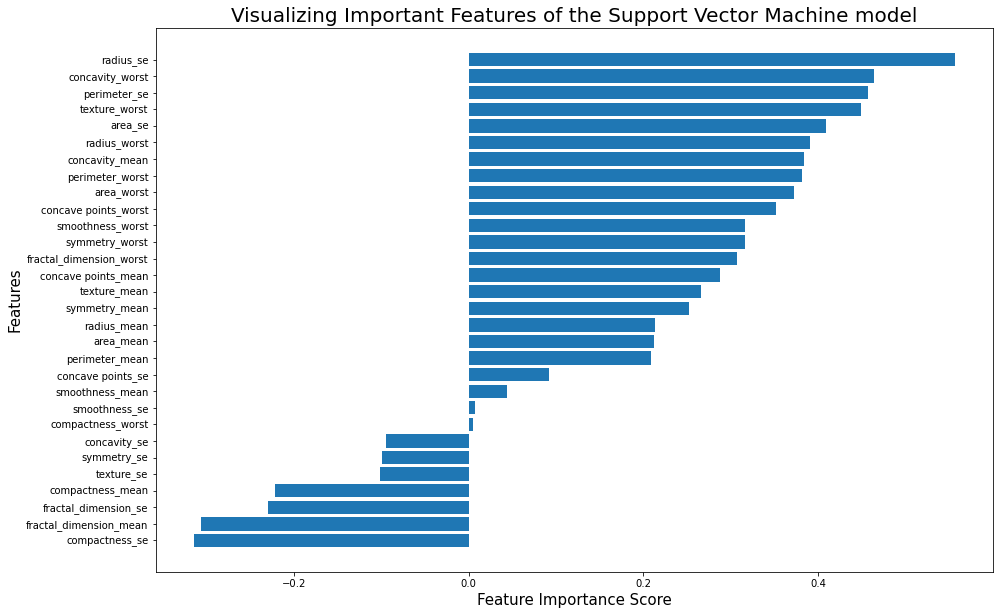

In [19]:
plt.figure(figsize=(15, 10))

feature_svm = pd.Series(svm_tuned.best_estimator_.coef_[0],index=train_features.columns).sort_values(ascending=False)

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    
    plt.yticks(range(len(names)), names)
    plt.xlabel('Feature Importance Score', fontsize=15)
    plt.ylabel('Features', fontsize=15)
    plt.title("Visualizing Important Features of the Support Vector Machine model", fontsize=20)
    
    plt.show()

print("These are the features sorted by their importance:")
f_importances(svm_tuned.best_estimator_.coef_[0], train_features.columns)

## Second ML Approach: Random Forrest Classifier (RFC)

In the second approach, I want to use a Random Forrest Classifier with Bayesian Optimization hyperparameter tuning for the 5 hyperparameters n_estimators, max_features, min_samples_split, criterion and min_impurity_decrease. Although we could extract the feature importance from the SVM approach above because we used a linear kernel, one drawback of SVMs is usually their low interpretability which is better with the RFC approach. In the following, I will explore whether I can get a better classifier with the RFC approach. The distadvantage of an RFC model is that it is slower than an SVM model because it generates a lot of different trees.

I will try to tune the following hyperparameters:
- n_estimators: the number of trees in the forrest
- max_features: the maximum number of features considered for splitting a node
- max_depth: the maximum number of levels in each decision tree
- min_samples_split: the minimum number of data points that will be placed in a node before it will be split
- criterion: the function we use to measure the quality of the split, e.g. the information yield
- min_samples_leaf: the minimum number of data points allowed in a lead node
- bootstrap = method for sampling data points

In [20]:
rfa = BayesSearchCV(
     RandomForestClassifier(),
     {
         'n_estimators': Integer(5, 500),
         'max_features': Categorical(['sqrt', 'log2']),
         'max_depth': Integer(10,300),
         'min_samples_split': Integer(2,20),
         'criterion': Categorical(['gini','entropy', 'log_loss']),
         'min_samples_leaf': Integer(1,200),
         'bootstrap': Categorical([True, False])
     },
     n_iter=100,
     random_state=0)

In [21]:
# fitting the best estimator, hiding warnings because we only get warnings that conditions were evaluated twice

with warnings.catch_warnings(record=True):
    rfc_tuned = rfa.fit(train_scaled_features, train_target)

In [22]:
# We check the score for the best estimator, the SVM function uses mean scoring of the subset accuracy

score_rfc = rfc_tuned.score(test_scaled_features, test_target)

print("The score based on the subset accuracy integrated in the SVM function of sklearn",
      "calculates the subset accuracy. The result is:",rfc_tuned.score(test_scaled_features, test_target),
    "% accuracy.")

The score based on the subset accuracy integrated in the SVM function of sklearn calculates the subset accuracy. The result is: 0.9736842105263158 % accuracy.


In [24]:
f1_rfc = f1_score(test_target,rfc_tuned.predict(test_scaled_features))

print("I will use the F1 score which is the harmonic mean of precision and recall because it is",
      "not depending on the balance between classes:",f1_rfc)

I will use the F1 score which is the harmonic mean of precision and recall because it is not depending on the balance between classes: 0.967741935483871


In [25]:
print("Taken together, the optimised RFC model gives over 96.7% accuracy in predicting whether a sample should",
     "be diagnosed as malign or benigh. The RFC model works exactly as good as the SVM model.",

"\n\nThe hyperparameters that deviate from the default are:", rfc_tuned.best_estimator_.get_params,

"\n\n The default for max_features is 'sqrt' (the number of samples to consider when looking for the",
"\nbest split is the square root of the total of features). The default for min_samples split is 2 and for",
"\min_samples_leaf is 1.")

Taken together, the optimised RFC model gives over 96.7% accuracy in predicting whether a sample should be diagnosed as malign or benigh. The RFC model works exactly as good as the SVM model. 

The hyperparameters that deviate from the default are: <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       max_features='log2', n_estimators=500)> 

 The default for max_features is 'sqrt' (the number of samples to consider when looking for the 
best split is the square root of the total of features). The default for min_samples split is 2 and for \min_samples_leaf is 1.


In [26]:
print("Moreover, we can extract the feature importance to compare it to the SVM model with the same performance:")

Moreover, we can extract the feature importance to compare it to the SVM model with the same performance:


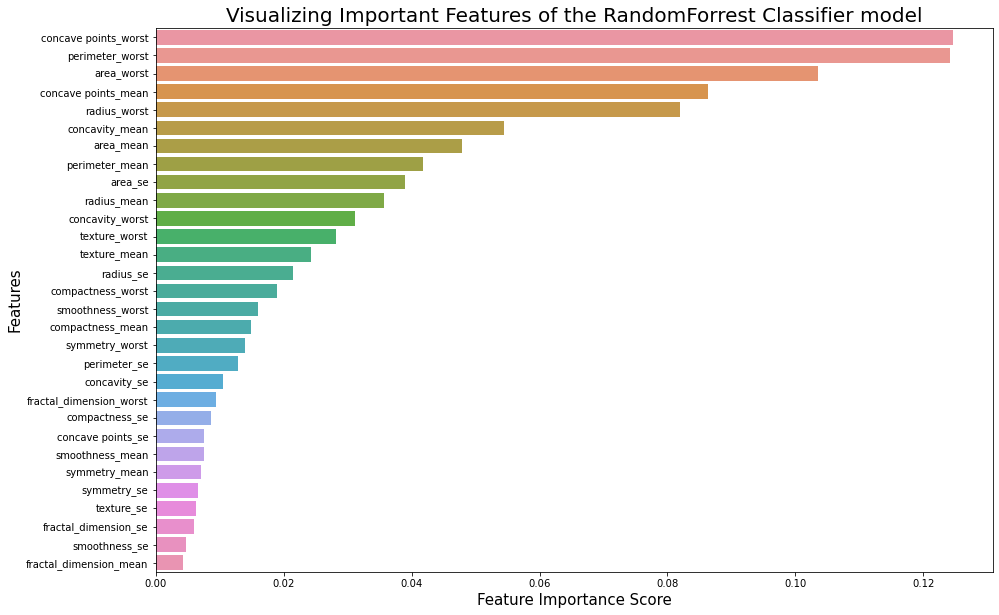

In [29]:
plt.figure(figsize=(15, 10))

feature_rfc = pd.Series(rfc_tuned.best_estimator_.feature_importances_,index=train_features.columns).sort_values(ascending=False)

# Creating a bar plot
sns.barplot(x=feature_rfc, y=feature_rfc.index)
plt.xlabel('Feature Importance Score', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.title("Visualizing Important Features of the RandomForrest Classifier model", fontsize=20)

plt.show()

## Evaluating the performance of the two ML approaches

In the following, I will compare the two presented models and compare their performance.

### Important features

In the first step, I will compare the most important features that led to the definition of the decision boundary in the SVM model or creation of the best tree in the RFC model.

In [30]:
# The ten most important features in the SVM model
feature_svm[:10]

radius_se               0.555821
concavity_worst         0.463779
perimeter_se            0.456769
texture_worst           0.448456
area_se                 0.408313
radius_worst            0.390666
concavity_mean          0.383731
perimeter_worst         0.380879
area_worst              0.372428
concave points_worst    0.351501
dtype: float64

In [31]:
# The ten most important features in the SVM model
feature_rfc[:10]

concave points_worst    0.124574
perimeter_worst         0.124117
area_worst              0.103497
concave points_mean     0.086287
radius_worst            0.082030
concavity_mean          0.054461
area_mean               0.047935
perimeter_mean          0.041764
area_se                 0.038987
radius_mean             0.035702
dtype: float64

As we see above, there is quite an overlap of the lists of the ten most important features for the two models. However, they are not ranked in the same order. Nevertheless, these two models identify a similar set of features as the most important features. The RFC model identifies even three features as the most outstanding most important features.

### Predictive Performance

In the next step, I will compare the predictive performance of the models and compare it to a naive classifier.

In [32]:
# Creating the naive classifier that classifies all samples as "M" for malign which would mean that we 
# diagnose every patient as a patient that has a dangerous tumor which would lead in the case of breast cancer
# to quite serious medical treatments which need to be avoided if it is not absolutely necessary

naive = np.empty(len(test_target))
naive.fill(1)

In [33]:
# Calculate accuracy for the different models
print("Accuracy of the naive classifier is:",accuracy_score(test_target,naive)*100,"%.")
print("Accuracy of the SVM model is:",accuracy_score(test_target, svm_tuned.best_estimator_.predict(test_scaled_features))*100,"%.")
print("Accuracy of the naive classifier is:",accuracy_score(test_target, rfc_tuned.best_estimator_.predict(test_scaled_features))*100,"%.")

print("\nThe F1 score for this naive classifier yields a score of:",f1_score(test_target,naive))
print("The F1 score for this SVM model yields a score of:",f1_svm)
print("The F1 score for this RFC model yields a score of:",f1_rfc)


Accuracy of the naive classifier is: 41.228070175438596 %.
Accuracy of the SVM model is: 97.36842105263158 %.
Accuracy of the naive classifier is: 97.36842105263158 %.

The F1 score for this naive classifier yields a score of: 0.5838509316770186
The F1 score for this SVM model yields a score of: 0.967741935483871
The F1 score for this RFC model yields a score of: 0.967741935483871


In [34]:
print("Classification report for the naive classifier:")
with warnings.catch_warnings(record=True):
    print(classification_report(test_target,naive))

print("\nClassification report for the SVM model:")
print(classification_report(test_target,svm_tuned.best_estimator_.predict(test_scaled_features)))

print("\nClassification report for the RFC model:")
print(classification_report(test_target,rfc_tuned.best_estimator_.predict(test_scaled_features)))

Classification report for the naive classifier:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        67
           1       0.41      1.00      0.58        47

    accuracy                           0.41       114
   macro avg       0.21      0.50      0.29       114
weighted avg       0.17      0.41      0.24       114


Classification report for the SVM model:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        67
           1       0.98      0.96      0.97        47

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


Classification report for the RFC model:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        67
           1       0.98      0.96      0.97        47

    accuracy                           0.97       

SVM and RFC model have the same predictive performance classify malign samples far better than the naive classifier. Both models have more than twice the accuracy of the naive classifier and a far better F1 score than the naive classifier. 

## Conclusion

Taken together, I trained two models: one based on Support Vector Machines, one based on a Random Forrest Classifier. Both models showed the same predictive performance with the same accuracy and F1 and performed far better than a naive classifier that would classify all samples as malign samples. The naive classifier had an accuracy of 41.2% which means that the misclassification rate would be 58.8%. This would lead to 58.8% of patients not receiving the treatment they would need (or would receive treatment although they don't need it). Being treated for breast cancer although they wouldn't need this treatment would mean surgical interventions and strong medical treatment regimes although not necessary and thereby it would lead to a drastic decrease in life quality.

On the other hand, both models developed here had an accuracy of about 97.4% which is the fraction of total samples that were correctly classified. This is already a very good result. We will look more specifically at different parameters of the predictive performance in the following.

According to the classification report given above, precision of both models was the same with about 0.98 for malign samples (1) and 0.97 for benign samples (0). Precision is the fraction of correct predictions in the positive class (true positives among true and false positives). This means that 2% of malign samples would be incorrectly classified as malign samples. These patients would be recommended for medical treatment against breast cancer although they don't need it. They are false positives.

However, it still means we would only misclassify 2% of patients that have a good, benign tumor and treat them although they don't need treatment. In a clinical setting, it is better to have false positives than false negatives because being false positive usually does not mean that patients will directly receive treatment but be subjected to further diagnoses and closer examination. Therefore, I am confident that these 2% of patients would be correctly classified as benign tumors in the follow-up diagnostics.

The recall describes how many of the positive samples were correctly predicted as positive by the classifier. This means how many malign tumors could we find and on the other hand (1-recall), how many did we miss, eg how many patients that need treatment would not be recommended for treatment? This is also known as sensitivity and true positive rate and is calculated as true poistives divided by the sum of true positives and false negatives. The recall for malign samples is 0.96 in both models. This means that we are correctly classifying 96% of the malign samples but are missing 4% of the malign samples which means that 4% of patients that need treatment wouldn't be recommended for treatment. Nevertheless, correctly identifying 96% of the malign tumors is still a very high and good result.

In conclusion, both models that I developed here are very successful in solving the task to develop a model that predicts malign samples from the 30 features extracted from images of breast masses.